In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
# hyper parameters
batch_size = 128
num_epochs = 100
seed = 42
out_dir = "./vae"

出力先のディレクトリを ``vae_2`` としている。潜在空間が2次元であるVAEの結果を意味する。

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [4]:
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)  # manual_seed_all()  ですべてのGPUのランダムseedをセット(並列GPU用)

MNIST のデータをロードする。前回と同じだけど標準化は[0,1]にしている。

In [5]:
train_data = datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("data", train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

### VAEのアーキテクチャ

VAEは、Autoencoderと似ているが、**Encoderの出力が正規分布の平均と共分散行列**になり、潜在表現zがその正規分布からサンプリングされる点が異なる。潜在表現zはランダムサンプリングされるため同じ入力画像Xを入れても毎回異なるzにマッピングされる。

Encoderは正規分布の平均ベクトル（mu）と分散共分散行列の対数（logvar）を出力する。ここでは、潜在表現 z は可視化しやすいように2次元としたので、平均ベクトルのサイズは2となる。分散共分散行列は対角行列と仮定しているため対角成分のみ取ってこちらも2次元ベクトルとなる。対数を取る理由がはっきりしないけどアンダーフローを防ぐためかな？

Encoderが出力した平均と分散を持つ正規分布から入力Xの潜在表現zをサンプリングする。

$z \sim N(\mu(X), \Sigma(X))$

ただ、これを普通にやると誤差逆伝搬ができないので **Reparameterization Trick** というのを使う。上の式でサンプリングするのではなく、

$\epsilon \sim N(0, I)$

$z = \mu(X) + \Sigma(X)^\frac{1}{2}\epsilon$

でzを計算する。このように計算すると和と積の演算だけで構成されるので計算グラフが構築でき、誤差逆伝搬ができるとのこと。PyTorchには ``normal_(mean=0, std=1)`` という正規乱数を生成するTensor Operationが実装されている。

ここがちょっとわからない。meanとstdを指定しても乱数生成できるみたいだけど*Reparameterization Trick*必要なのかな？多次元正規分布になるとできないのだろうか？

上のアーキテクチャをPyTorchのコードで書くと下のようになる。

In [6]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)  # mu
        self.fc22 = nn.Linear(512, 2)  # logvar
        
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    # μ(平均)とlogvar(分散)を返す  # logvar: logΣ
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    # N(0,1) の正規分布に
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    # 潜在変数(2次元)を復元(784次元)
    def decode(self, x):
        h = self.relu(self.fc3(x))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

ちょっと数式とコードの対応関係を補足すると logvar は logΣ にあたる。

``std = logvar.mul(0.5).exp_()`` は、

$std = exp(0.5*log\Sigma) = exp(log\Sigma^\frac{1}[2]) = \Sigma^\frac{1}{2}$<br>
となる。よって、``eps.mul(std).add_(mu)`` は、

$\epsilon*\Sigma\frac{1}{2} + \mu$<br>
となり、先の式とコードが一致することがわかる！**数式だとεはスカラーっぽいけど実装ではベクトルになっている。**潜在表現の各次元ごとに異なる乱数をかけるようだ。

スカラーでもよいのかな？

### VAEの損失関数
VAEの損失関数は既存のものではなく、独自の定義が必要。

In [8]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")  # reduction="sum"  

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

このコードを理解するのがとても難しかった。数式の導出は

- [Variational Autoencoder徹底解説 - Qiita](https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24)
- [Variational Autoencoder: Intuition and Implementation - Agustinus Kristiadi's Blog](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
- [Tutorial - What is a variational autoencoder? – Jaan Altosaar](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
- [Variational Auto Encoder](http://nzw0301.github.io/notes/vae.pdf)

を見ていただくほうがよいと思う。最終的には下の目的関数が出て来るのだがそこまでのたどり着き方にはいくつかアプローチがあるようだ。

VAEの最終的な目的関数は、

$logP(X) - D_KL[Q(z|X)||P(z|X)] = E[logP(X|z)] - D_KL[Q(z|X)||P(z)]$<br>
となる。左辺のKL divergenceは$D_KL[Q(z|X)||Pz|X)] \geq 0$なので<br>
$logP(X) \geq E[logP(X|z) - D_KL[Q(z|X)||P(z)]$<br>
が成り立つ。 たとえば、 12-2=10 のとき 12 >= 10

左辺がデータXの対数尤度なので生成モデルにおいて最大化したい値になる。右辺は **変分下限（ELBO: evidence lower bound）** と呼び、対数尤度の下限となる。ここで、対数尤度を最大化する問題を**変分下限を最大化する問題に置き換える**のがポイント。変分下限をできるだけ大きくしてやれば、それより大きい対数尤度も大きくなるというわけ。変分下限を最大化するには、

$E_{Q(z|X)}[logP(X|z)] \to max$<br>
$D_{KL}[Q(z|X)||P(z)] \to min$

とすればよい。簡単のため期待値の分布は省略してたけど最初の式をきちんと導出していくと Q(z|X) になることがわかる。

#### Reconstriction Loss
---
実はここの理解がちょっと怪しい。尤度最大化って交差エントロピーの最小化と等価で正しい？ときどき一部の論文でlossの式に尤度が書いてあってちょっと混乱する。

$E_{Q(z|X)}[logP(X|z)] \to max$

から見ていく。確率分布で書かれているのでわかりにくいが、**Q(z|X) は入力画像Xを潜在空間zにマッピングしているためEncoderとみなせる。**また、**P(X|z) は潜在空間zから元の画像XにマッピングしているためDecoderとみなせる。**つまり、この式は入力画像Xを潜在空間zに落としてそこからXに戻したときの対数尤度を最大化しろという意味だと解釈できる。

この対数尤度の最大化は入力画像 $X$と再構成画像 $\hat{X}$ の交差エントロピーの最小化とみなせる。つまり、数式で表すと下の部分と一致する。これをReconstruction Lossと呼ぶ。

```python
recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
```

#### KL Divergence
---
次はこの項。

$D_{KL}[Q(z|X)||P(z)] \to min$

先に述べたように Q(z|X) は入力画像Xを潜在空間zにマッピングしているためEncoderとみなせる。つまり、**Encoderで入力画像Xをマッピングした分布 Q(z|X) が P(z) に近くなるようにしろという制約** と解釈できる。

ここで、**P(z) は簡単のため平均0、分散1の多次元正規分布 N(0, I) と仮定する。**

先に書いたようにEncoderの出力は N(μ(X), Σ(X)) の正規分布に従うようにしたため、上の式は

$D_{KL}[N(\mu(X), \Sigma(X))||N(0, I)]$

となる。多次元正規分布間のKL Divergenceは下の簡単な式で求まる。

$D_{KL}[N(\mu(X), \Sigma(X))||N(0, I)] = -\frac{1}{2}\sum_{k}(1+log\sum(X) - \mu(X)^2 - \sum(x))$

参考: [多変量正規分布の場合のKullback Leibler Divergenceの導出 - Qiita](https://qiita.com/kenmatsu4/items/c107bd51503462fb677f)

これをコードで書くと

```python
kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
```

となる。この ``kld`` は**潜在空間zが N(0, I) にちらばるようにする正則化項とみなせる**。あとで実際に潜在空間を描画してみるとこの正則化が正しく機能していることがわかる。

### 訓練ループ

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss  


def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        train_loss,
        test_loss))

    # logging
    loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
# save the training model
np.save('{}/loss_list.npy'.format(out_dir), np.array(loss_list))
np.save('{}/test_loss_list.npy'.format(out_dir), np.array(test_loss_list))
torch.save(model.state_dict(), '{}/vae.pth'.format(out_dir))

epoch [2/100], loss: 186.2006 test_loss: 165.7418
epoch [3/100], loss: 165.0283 test_loss: 161.2336
epoch [4/100], loss: 161.4707 test_loss: 158.5514
epoch [5/100], loss: 159.2905 test_loss: 156.7968
epoch [6/100], loss: 157.6140 test_loss: 155.5126
epoch [7/100], loss: 156.1821 test_loss: 154.4340
epoch [8/100], loss: 155.0733 test_loss: 153.7582
epoch [9/100], loss: 154.1412 test_loss: 152.9314
epoch [10/100], loss: 153.3089 test_loss: 152.1763
epoch [11/100], loss: 152.6631 test_loss: 152.0126
epoch [12/100], loss: 152.0384 test_loss: 151.8314
epoch [13/100], loss: 151.4688 test_loss: 150.9311
epoch [14/100], loss: 151.0280 test_loss: 150.9039
epoch [15/100], loss: 150.5297 test_loss: 150.0310
epoch [16/100], loss: 150.0539 test_loss: 150.1656
epoch [17/100], loss: 149.7146 test_loss: 150.2260
epoch [18/100], loss: 149.2849 test_loss: 149.9245
epoch [19/100], loss: 148.9414 test_loss: 149.2633
epoch [20/100], loss: 148.6380 test_loss: 149.3238
epoch [21/100], loss: 148.3435 test_los

### 学習曲線

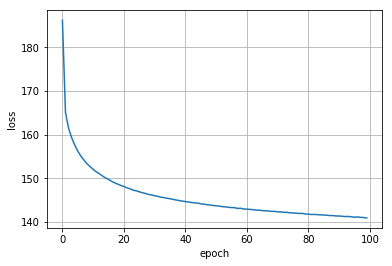

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

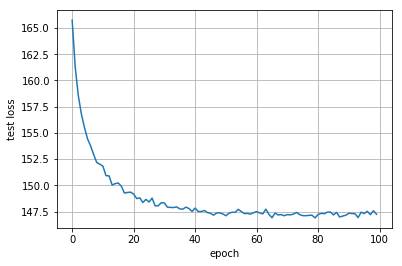

In [11]:
test_loss_list = np.load('{}/test_loss_list.npy'.format(out_dir))
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.grid()

テストlossも減っており、学習が進んでいることが確認できる。

### 入力画像と再構成画像の比較
上が入力画像で下が再構成画像。

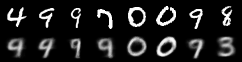

In [12]:
from IPython.display import Image
Image("{}/reconstruction_10.png".format(out_dir))

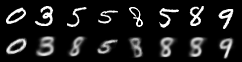

In [13]:
Image("{}/reconstruction_100.png".format(out_dir))

10エポック目だとあまり再現できてないが、100エポック目だとある程度は再現できている。ただ、潜在空間を2次元とかなり絞ったのであまりくっきりと再現できていない。潜在空間を20次元にすると

![](vae/div20.png)

こんな感じでほぼ再構成できることがわかる。潜在空間が2次元だとテストlossは150くらいで収束するが、20次元にするとテストlossは90台まで下がる。

### 潜在空間の可視化
最後にテストデータを使って潜在空間を可視化しよう。

In [14]:
model.load_state_dict(torch.load("{}/vae.pth".format(out_dir),
                                map_location=lambda storage,
                                loc: storage))
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encode(images.to(device))
mu, logvar = z
mu, logvar = mu.cpu().data.numpy(), logvar.cpu().data.numpy()
print(mu.shape, logvar.shape)

(10000, 2) (10000, 2)


各入力画像Xごとに正規分布のパラメータ μ(X), Σ(X) が出力されるがここでは平均 μ(X) の場所に点をプロットすることにする。ランダムサンプリングすると平均の場所にマッピングされる可能性が一番高い。

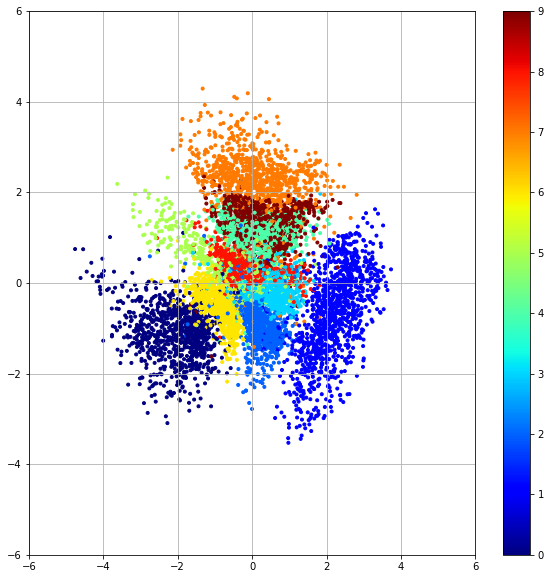

In [15]:
import pylab
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.grid()

潜在空間zは平均0で分散Iの正規分布 P(z) = N(0, I) 上にデータが散らばっており、損失関数のKL divergenceの正則化項が効いていることがわかる。